<a href="https://colab.research.google.com/github/VMBoehm/UndergradStudentProjects/blob/master/Jamie_and_Lister/VanessasNotebooks/PeakCounts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# applying our methods to lensing convergence peak counts

In [15]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [82]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],'size':18})


rc('text', usetex=True)

In [70]:

datapath='../data/'


### the paper: https://arxiv.org/pdf/1810.01781.pdf

### load the data

In [71]:
# these are the peaks counts
data_scaled = np.load(datapath+'peakcnts_lhc.scaled.npy',allow_pickle=True)
# these are the cosmo params
cosmo_params = np.load(datapath+'params.npy')
# this is the covariance for the likleihood
covariance = np.load(datapath+'covariance.npy',allow_pickle=True)

In [72]:
# 101 cosmologies, 10000 simulations per cosmology, 50 density bins (levels of 'flooding')
data_scaled.shape

(101, 9999, 50)

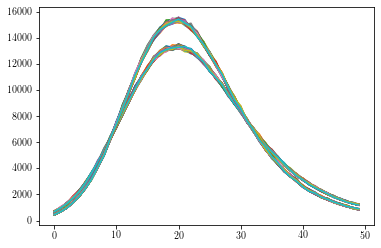

In [73]:
# this is what the data looks like for 2 different cosmologies
plt.plot(data_scaled[40,0:100,:].T)
plt.plot(data_scaled[44,0:100,:].T)
plt.show()

### The data

In [74]:
# We pick a realization at a specific cosmology to be our data (you can change this!)
# right now we choose a cosmology which is fairly close to the fiducial one (see below)
index = 54
data  = data_scaled[index][0]
true_params = cosmo_params[index]
print(true_params)

[0.124  0.3028 2.3174]


### Covariance Matrix

In [75]:
# compute covariance from covariance sims
Cinv = np.linalg.inv(covariance)

In [78]:
# these are the fiducial parameter, i.e. the parameters the covariance was measured at 
fid_params = np.load(datapath+'theta.fid.npy',allow_pickle=True)
print(fid_params)
labels =[r'$m_\mu$',r'$\Omega_m$',r'$A_s$']

[0.1 0.3 2.1]


### Constructing the data likelihood

In [23]:
# average over all simulations for each cosmology
means      = np.mean(data_scaled, axis=1)

#### Forward Model: Gaussian process interpolation of  means

In [24]:
# A Gaussian process is a regression model, it learns to map x-> f(x) from some training data. 
# In our case x are the cosmological parameters and f(x) are the peak counts

import sklearn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C


kernel = C(1.0, (1e-4, 1e4)) * RBF(1, (1e-4, 1e4))
#Instanciate a Gaussian Process model
gp     = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)


# fit on means and parameters
gp.fit(cosmo_params,means)

#use the GP prediction to build the model
def fwdmodel(theta):
    pred, stdev = gp.predict(np.array(theta).reshape(1,3),return_std=True)
    return np.squeeze(pred.T)




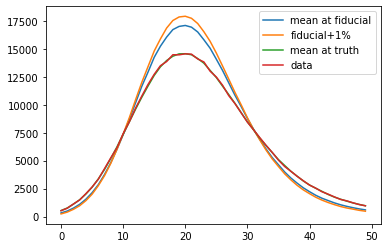

In [25]:
# Check how well the Gaussian process is doing

plt.plot(fwdmodel(fid_params), label='mean at fiducial')
plt.plot(fwdmodel(fid_params*1.01), label= 'fiducial+1%')
plt.plot(fwdmodel(true_params), label='mean at truth')
plt.plot(data, label='data')
plt.legend()
plt.show()

In [37]:
# likelihood
# We assume a Gaussian likelihood for the peak counts. 
# Can you think of reasons why this is a reasonable assumption?
# Hint: Peak counts are a binned statistic (a sum of a random number)

def log_likelihood(data, params):
    mu  = fwdmodel(params)
    x   = data - mu
    # linalg.slogdet is numerically more stable than np.log(linalg.det())
    _, logdet = np.linalg.slogdet(Cinv)
    x   = np.squeeze(x)
    logp= -0.5*np.dot(np.dot(x, Cinv),x)+0.5*logdet-0.5*len(x)*np.log(2*np.pi)
    return np.squeeze(logp)

In [88]:
def log_prior(params, params_fid):
    sigma = np.sqrt(params_fid*10)
    Cinv  = np.diag(1./sigma**2)
    _, logdet = np.linalg.slogdet(Cinv)
    x = params-params_fid
    log_prior = -0.5*np.dot(np.dot(x, Cinv),x)+0.5*logdet-0.5*len(x)*np.log(2*np.pi)
    return log_prior

In [57]:
# check if output makes sense
print(-log_likelihood(data,true_params))
print(-log_prior(fid_params,fid_params))
print(-log_prior(true_params,fid_params)-likelihood(data,true_params))

426.4627767277797
4.151078130383086
430.6159924922331


### posterior

In [58]:
neglogpost = lambda x: -log_likelihood(data, x)-log_prior(x,fid_params)

### derivatives

In [59]:
import numdifftools as nd
# gradient
grad = nd.Gradient(neglogpost)
# hessian
hess = nd.Hessian(neglogpost)

### find minima

In [95]:
import warnings
from scipy.optimize import minimize

log_posts = [] 
param_ests= []
with warnings.catch_warnings(record=True):
    for jj, theta_ini in enumerate(np.sqrt(fid_params*10)*np.random.randn(10,3)+fid_params):
        print(jj)
        for method in ['Nelder-Mead']:#,'Nelder-Mead','Powell','CG','BFGS','Newton-CG','L-BFGS-B','TNC','COBYLA','SLSQP','trust-constr','dogleg','trust-ncg','trust-exact','trust-krylov']:
            res = minimize(neglogpost,theta_ini,jac=grad,hess=hess,method=method)
            if res['success']:
                sign,_ = np.linalg.slogdet(hess(res['x']))
                if sign >0:
                    log_posts.append(neglogpost(res['x']))
                    param_ests.append(res['x'])
                    print('minimum found')
param_ests= np.asarray(param_ests)
log_posts= np.asarray(log_posts)

0
minimum found
1
2
minimum found
3
minimum found
4
minimum found
5
minimum found
6
minimum found
7
minimum found
8
minimum found
9
minimum found


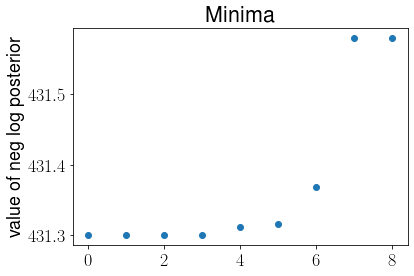

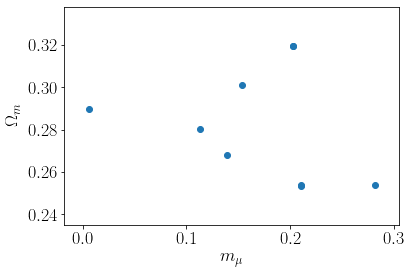

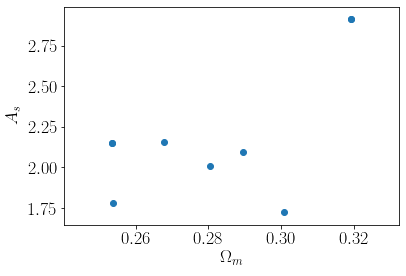

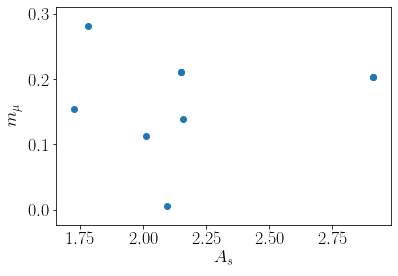

In [96]:
# did they all land in the same minimum?
index       = np.argsort((log_posts))
plt.title('Minima')
plt.plot(log_posts[index],ls='', marker='o')
plt.ylabel('value of neg log posterior')
plt.show()

for ii in range(param_ests.shape[-1]):
    if ii==2:
        plt.scatter(param_ests[index,ii],param_ests[index,0])
        plt.xlabel(labels[ii])
        plt.ylabel(labels[0])
    else:
        plt.scatter(param_ests[index,ii],param_ests[index,ii+1])
        plt.xlabel(labels[ii])
        plt.ylabel(labels[ii+1])
    plt.show()
# parameters are pretty much all over the place

In [97]:
### let's look at the lowest minimum
index       = np.argsort((log_posts))
print(log_posts[index[0]])
best_params = param_ests[index[0]]
print(best_params, true_params, fid_params)

431.2999625534561
[0.13926462 0.26785645 2.15690184] [0.124  0.3028 2.3174] [0.1 0.3 2.1]


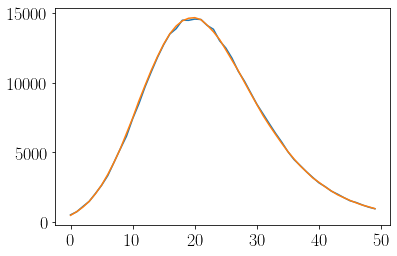

In [98]:
plt.plot(data)
plt.plot(fwdmodel(best_params))

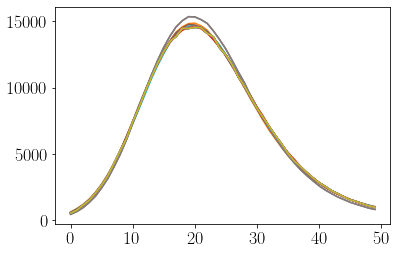

In [99]:
# let's look at all minima:
plt.plot(data)
for ii in range(len(param_ests)):
    plt.plot(fwdmodel(param_ests[ii]))
    plt.plot(data)
## all of them seem to be consistent with the data!

In [101]:
def log_Gaussian(x,mu,cov):
    mu   = fwdmodel(params)
    x    = x - mu
    Cinv = np.linalg.inv(cov)
    _, logdet = np.linalg.slogdet(Cinv)
    logp = -0.5*np.dot(np.dot(x, Cinv),x)+0.5*logdet-0.5*len(x)*np.log(2*np.pi)
    return logp

### Task: use the log_Gaussian function, the parameters at the lowest minimum and the hessian around this minimum to build your approximation to the posterior as we did in the other example.